# Analysing Covid and Flight data for each city

In [1]:
from urllib.request import urlopen
from io import StringIO
import csv

import sys
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
data = urlopen("https://raw.githubusercontent.com/shantanutrip/covid_flight_analysis/master/Resultant_Data/covid_flight_count_data.csv").read().decode('ascii','ignore')
dataFile = StringIO(data)
csvReader = csv.reader(dataFile)
rows = [row for row in csvReader if row[0]!='city']

city_list = []
for row in rows:
    if row[0] not in city_list:
        city_list.append(row[0])

covid_flight_count_data = {}

In [3]:
def get_covid_and_flight_count_for(city_name):
    temp = city_name

    flight_in = []
    flight_out = []
    flight_all = []
    total_num = []
    all_dates = []
    rate_of_increase = []
    Date = []
    count = 0
    prevRow = None
    city_dict = {}
    

    for row in rows:
        if row[0] == temp:
            count += 1
            flight_in.append(int(row[4]))
            flight_out.append(int(row[5]))
            flight_all.append(int(row[4])+int(row[5]))
            total_num.append(int(row[2]))
            all_dates.append(row[1])
            if prevRow == None:
                rate_of_increase.append(0)
            else:
                rate_of_increase.append(int(row[2]) - int(prevRow[2]))
            prevRow = row
            if count%3==1:
                Date.append(row[1][-5:])
            else:
                Date.append('')
    
    city_dict['flight_in'] = flight_in
    city_dict['flight_out'] = flight_out
    city_dict['flight_all'] = flight_all
    city_dict['rate_of_increase'] = rate_of_increase
    city_dict['Date'] = Date
    city_dict['all_dates'] = all_dates
    city_dict['count'] = count
    city_dict['total_num'] = total_num
    covid_flight_count_data[city_name] = city_dict
    
    return city_dict

In [4]:
def plot_covid_and_flight_count_for(city_name):
    
    if city_name not in covid_flight_count_data:
        get_covid_and_flight_count_for(city_name)
    
    city_dict = covid_flight_count_data[city_name]
    
    temp = city_name

    flight_in = city_dict['flight_in']
    flight_out = city_dict['flight_out']
    flight_all = city_dict['flight_all']
    total_num = city_dict['total_num']
    rate_of_increase = city_dict['rate_of_increase']
    Date = city_dict['Date']
    count = city_dict['count']


    X = [i+1 for i in range(count)]

    plt.title("Data in %s" %(city_name))
    plt.xlabel("date")
    plt.ylabel("number")
    
    city_dict['flight_in'] = flight_in
    city_dict['flight_out'] = flight_out
    city_dict['flight_all'] = flight_all
    city_dict['rate_of_increase'] = rate_of_increase
    city_dict['Date'] = Date
    
    
    plt.plot(X, total_num, 'r', label='cases')
    plt.plot(X, flight_in, 'b', label='flight_in')
    plt.plot(X, flight_out, 'g', label='flight_out')
    plt.plot(X, flight_all, 'y', label='flight_all')
    plt.plot(X, rate_of_increase, 'm', label='rate_of_increase')
    plt.scatter(X, total_num, marker='o', color='black', s=10)
    plt.scatter(X, flight_in, marker='o', color='black', s=10)
    plt.scatter(X, flight_out, marker='o', color='black', s=10)
    plt.scatter(X, flight_all, marker='o', color='black', s=10)
    plt.scatter(X, rate_of_increase, marker='o', color='black', s=10)
    plt.xticks(X, Date, rotation=90)

    plt.legend()
    plt.grid(linewidth=0.3)
    plt.show()
    #plt.savefig('image_1/%s.jpg' % temp, dpi=300)

    plt.close()

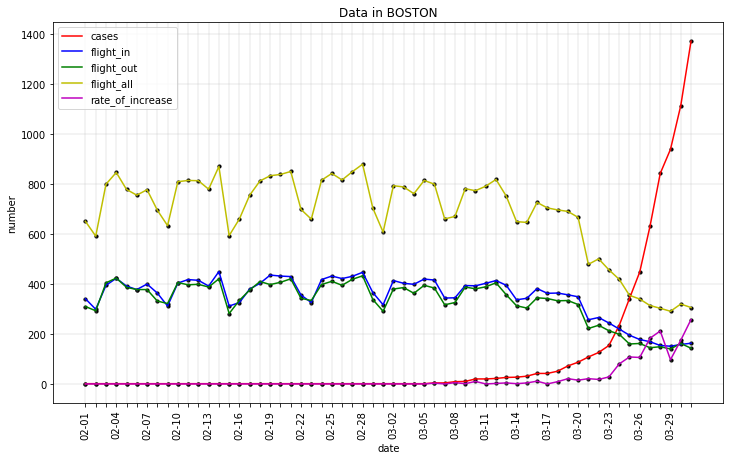

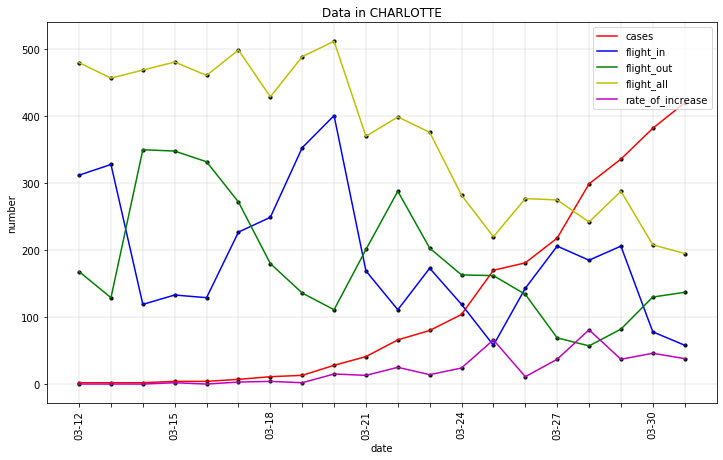

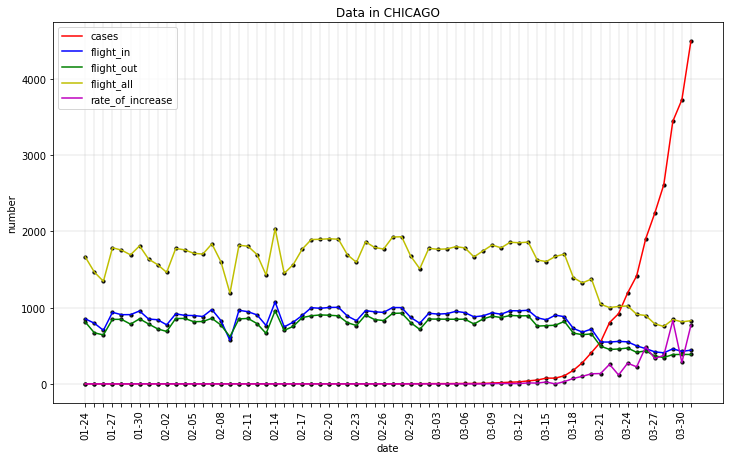

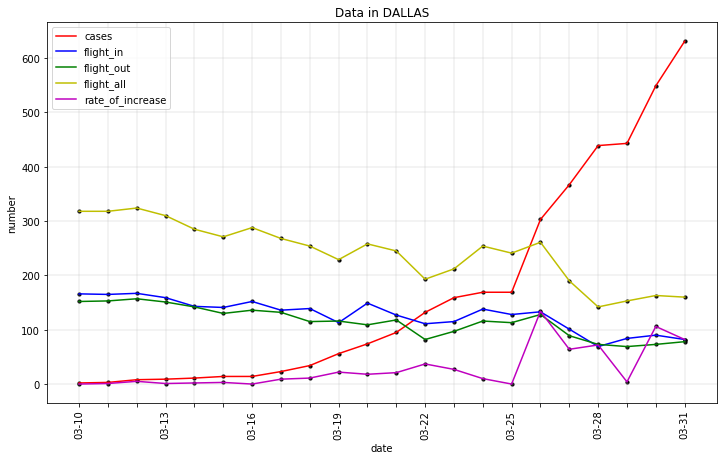

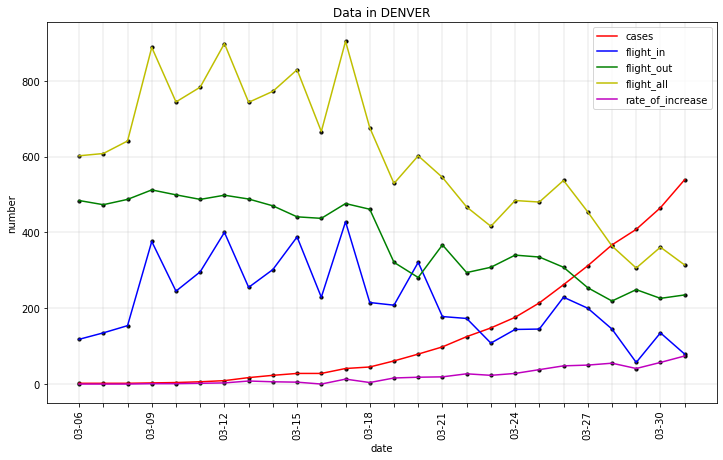

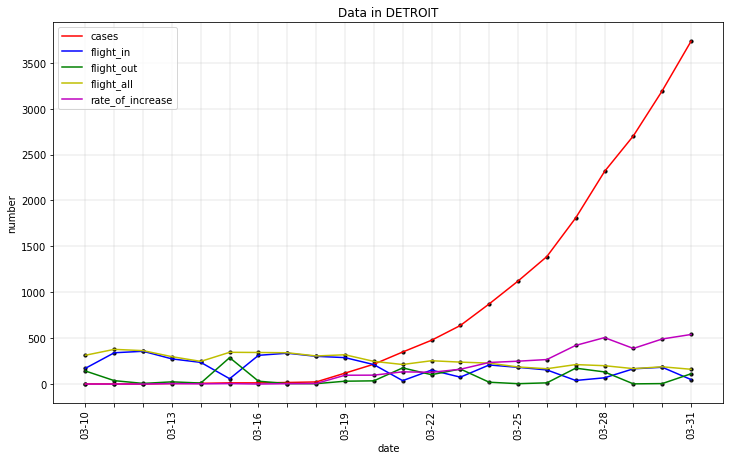

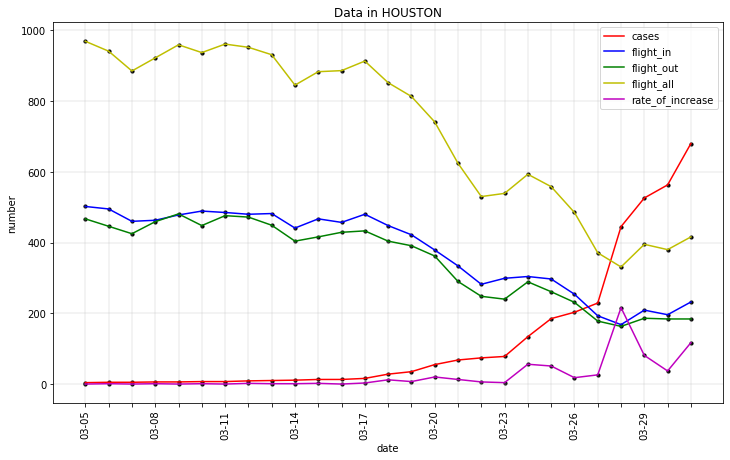

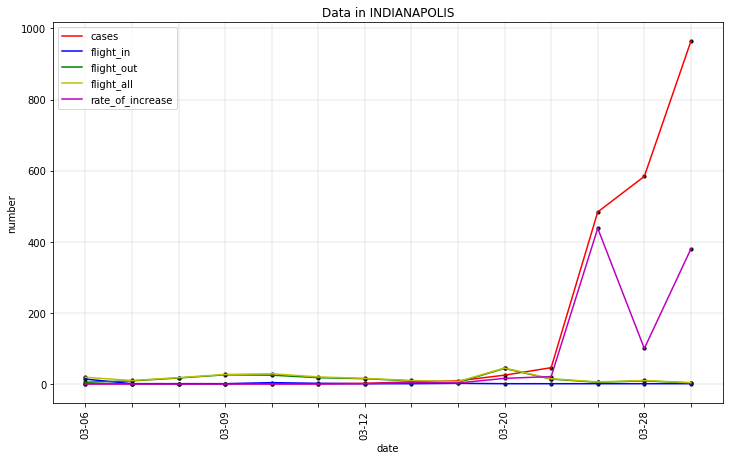

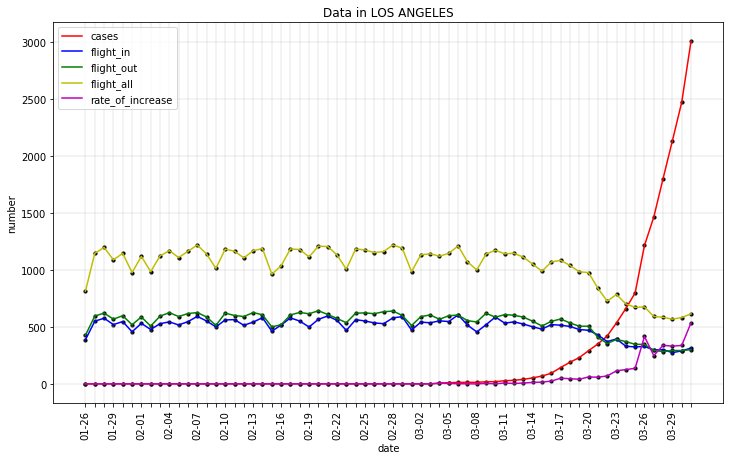

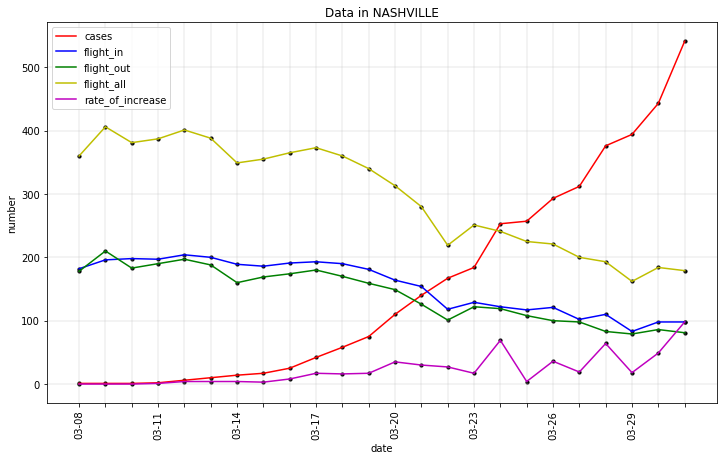

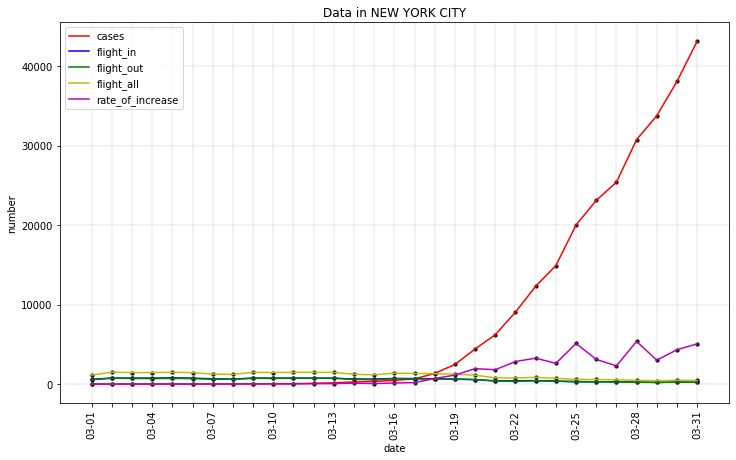

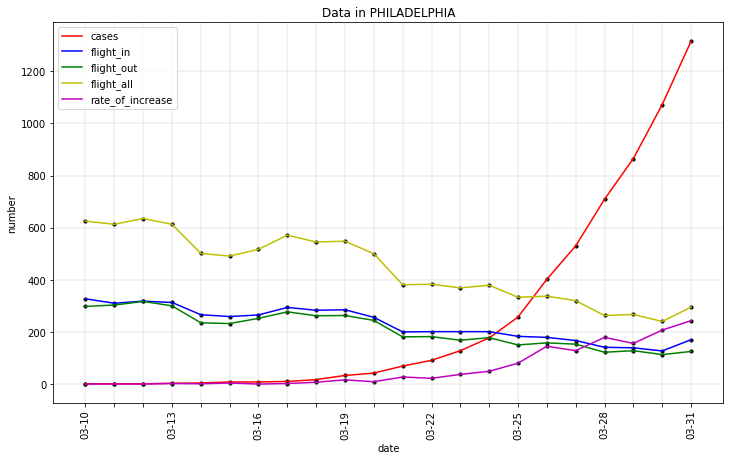

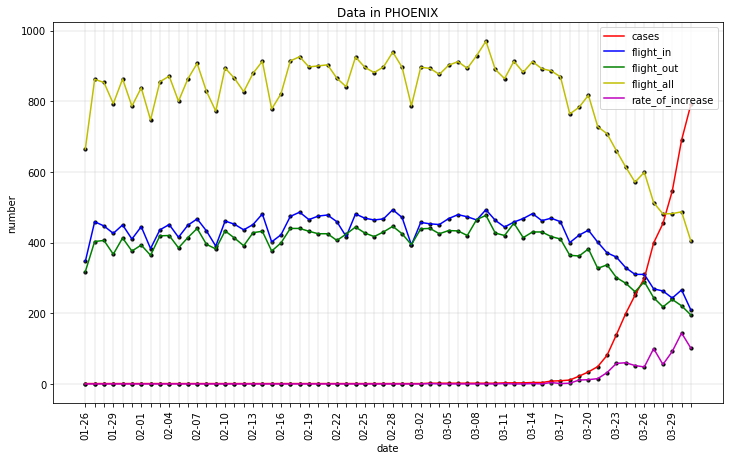

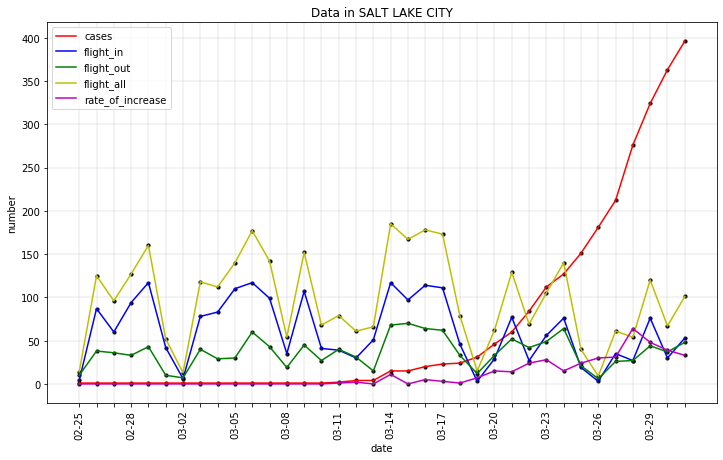

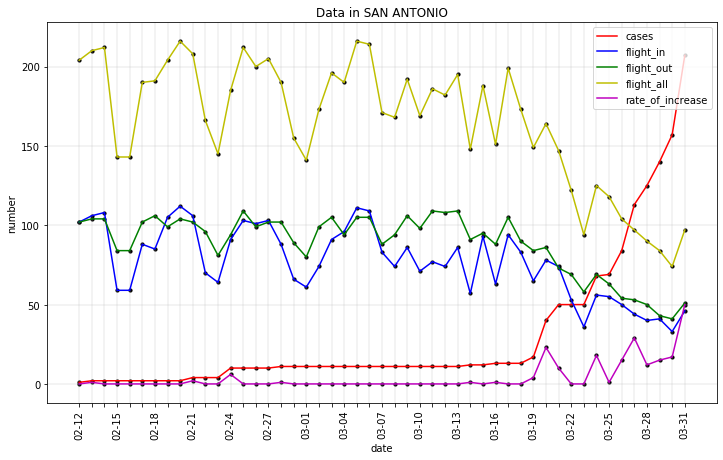

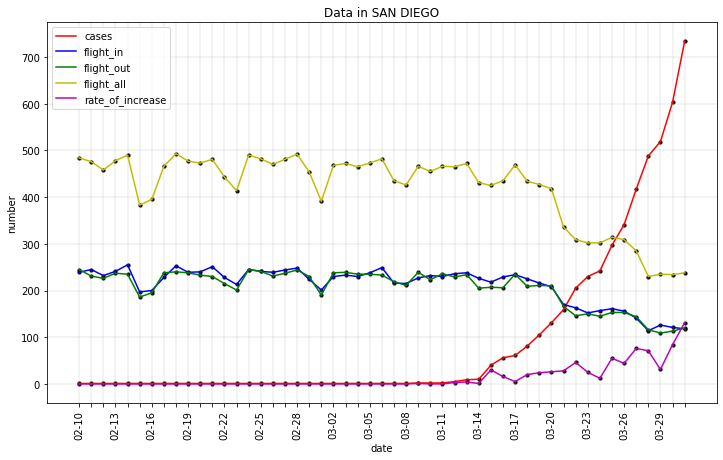

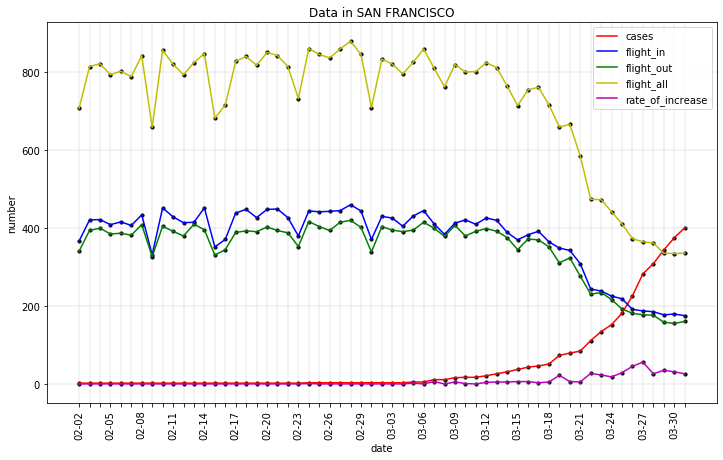

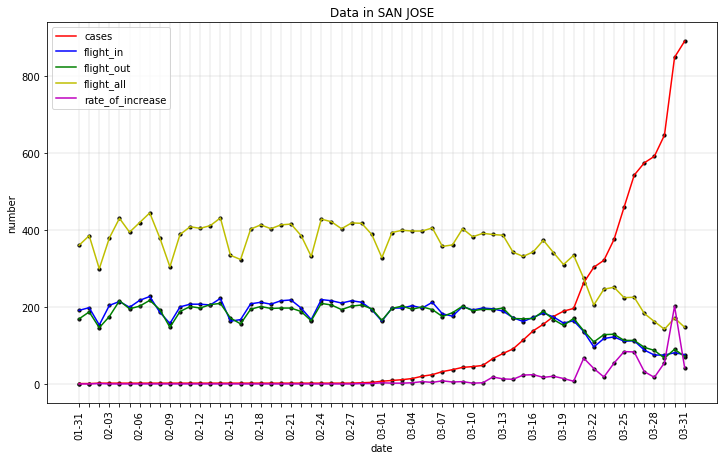

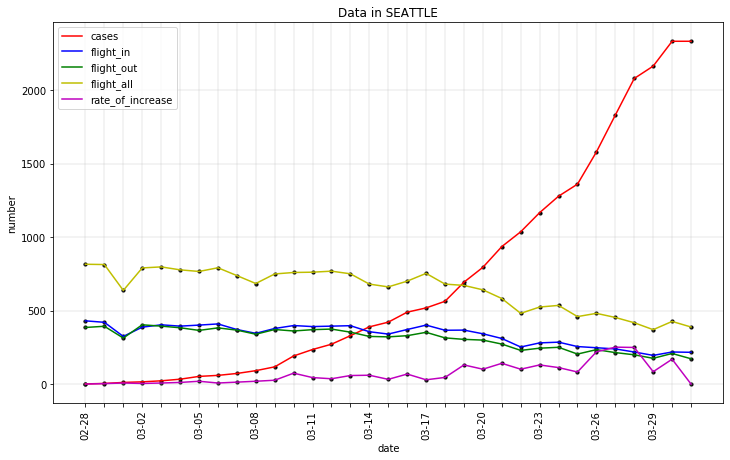

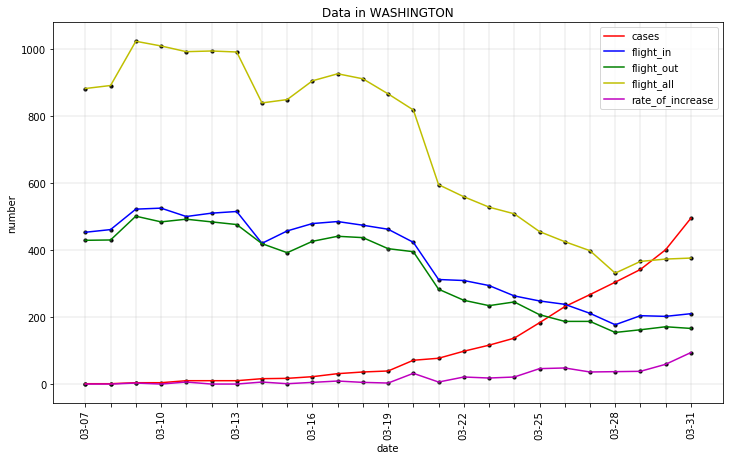

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7 #This makes the figure's width 5 inches, and its height 10 inches.

for city_name in city_list:
    get_covid_and_flight_count_for(city_name)
    plot_covid_and_flight_count_for(city_name)

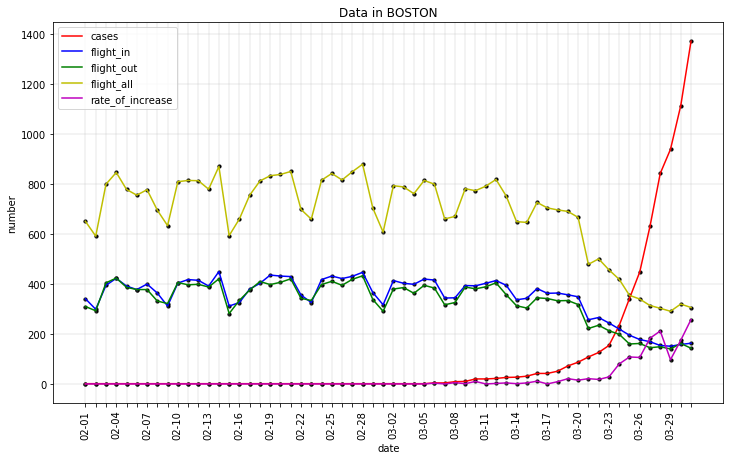

In [6]:
plot_covid_and_flight_count_for('BOSTON')

## Few Obeservations:

1. As the Covid cases increase, the number of flights start going down. 

2. The actual increase in covid for most of the cities starts taking place from 15th to 25th March. To be precise, 17th - 23rd March. Generally, it is during this time period that we observe that the rate of increase graph starts fluctuating.

3. The immediate effect of sudden increase in counts during these dates is that people stop using flights and the first plummet in the flight graph, for most of the cities is seen in the same week.

4. This means that the first 2 weeks of March had a very major role in the spread of the pandemic. This was the time when COVID silently implanted itself in most of the people.

# Analysing Pairwise Covid data 

In [7]:
flight_data = pd.read_csv('../Resultant_Data/inter_city_flight_data.csv')

In [8]:
def merge_dates(dates1, dates2):
    lst = list(set(dates1 + dates2))
    lst.sort()
    return lst

In [9]:
def get_daily_count_of_flights_from(city1, city2):
    return flight_data[
        (flight_data['from_city'] == city1) 
        & (flight_data['to_city'] == city2)].groupby('day').count()['from_city']

In [10]:
#https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd
def dynamic_time_warping(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix, dtw_matrix[n][m]

In [11]:
def get_city_datewise_merged_data(city1, city2):
    flight_data_1_to_2 = get_daily_count_of_flights_from(city1, city2)
    flight_data_2_to_1 = get_daily_count_of_flights_from(city2, city1)
    flight_data_1_to_2_date_list = list(flight_data_1_to_2.index)
    flight_data_2_to_1_date_list = list(flight_data_2_to_1.index)
    
    merged_dates = []
    merged_dates = merge_dates(merged_dates, covid_flight_count_data[city1]['all_dates'])
    merged_dates = merge_dates(merged_dates, covid_flight_count_data[city2]['all_dates'])
    merged_dates = merge_dates(merged_dates, flight_data_1_to_2_date_list)
    merged_dates = merge_dates(merged_dates, flight_data_2_to_1_date_list)
    
    ret_data = {}
    total_dates = len(merged_dates)
    ret_data['dates'] = merged_dates
    ret_data['city1_covid'] = [0] * total_dates
    ret_data['city2_covid'] = [0] * total_dates
    ret_data['city1_roi'] = [0] * total_dates
    ret_data['city2_roi'] = [0] * total_dates
    ret_data['flight1_2'] = [0] * total_dates
    ret_data['flight2_1'] = [0] * total_dates
    ret_data['total_flight'] = [0] * total_dates
    ret_data['city1'] = city1
    ret_data['city2'] = city2
    ret_data['dtw'] = -1
    ret_data['dtw_matrix'] = -1
    
    indx = 0
    for day in merged_dates:
        if day in covid_flight_count_data[city1]['all_dates']:
            indx2 = covid_flight_count_data[city1]['all_dates'].index(day)
            ret_data['city1_covid'][indx] = covid_flight_count_data[city1]['total_num'][indx2]
            ret_data['city1_roi'][indx] = covid_flight_count_data[city1]['rate_of_increase'][indx2]
                                                                     
        if day in covid_flight_count_data[city2]['all_dates']:
            indx2 = covid_flight_count_data[city2]['all_dates'].index(day)
            ret_data['city2_covid'][indx] = covid_flight_count_data[city2]['total_num'][indx2]
            ret_data['city2_roi'][indx] = covid_flight_count_data[city2]['rate_of_increase'][indx2]
        
        if day in flight_data_1_to_2_date_list:
            indx2 = flight_data_1_to_2_date_list.index(day)
            ret_data['flight1_2'][indx] = flight_data_1_to_2[indx2]
            ret_data['total_flight'][indx] += flight_data_1_to_2[indx2]
        
        if day in flight_data_2_to_1_date_list:
            indx2 = flight_data_2_to_1_date_list.index(day)
            ret_data['flight2_1'][indx] = flight_data_2_to_1[indx2]
            ret_data['total_flight'][indx] += flight_data_2_to_1[indx2]
        
        indx += 1
    
    ret_data['dtw_matrix'], ret_data['dtw'] = dynamic_time_warping(ret_data['city1_covid'], ret_data['city2_covid'])
    return ret_data

### Get pairwise city data

In [12]:
pairwise_city_data = {}
total_cities = len(city_list)
for i in range(0,total_cities):
    city1 = city_list[i]
    for j in range(i + 1,total_cities):
        city2 = city_list[j]
        if(city1 not in pairwise_city_data):
            pairwise_city_data[city1] = {}
        if(city2 not in pairwise_city_data):
            pairwise_city_data[city2] = {}
        pairwise_city_data[city1][city2] = get_city_datewise_merged_data(city1, city2)
        pairwise_city_data[city2][city1] = pairwise_city_data[city1][city2]

In [13]:
def plot_single_city_on_merged_city_graph(city, color):
    X = [i+1 for i in range(covid_flight_count_data[city]['count'])]
    plt.plot(X, covid_flight_count_data[city]['total_num'], color, label=city + ' cases')

In [14]:
def plot_merged_cities(city1, city2):
    citywise_merged_data = None
    if (city1 not in pairwise_city_data or city2 not in pairwise_city_data[city1]):
        citywise_merged_data = get_city_datewise_merged_data(city1, city2)
    else:
        citywise_merged_data = pairwise_city_data[city1][city2]
    count = len(citywise_merged_data['dates'])
    X = [i+1 for i in range(count)]
    merged_dates = [m[5:] if indx % 4 == 0 else '' for indx, m in enumerate(citywise_merged_data['dates'])]
    
    plt.title("Covid data of " + city1 + " and " + city2)
    plt.xlabel("date")
    plt.ylabel("number")
    plt.plot(X, citywise_merged_data['city1_covid'], 'r', label = city1 + ' cases')
    plt.plot(X, citywise_merged_data['city2_covid'], 'g', label = city2 + ' cases')
    plt.scatter(X, citywise_merged_data['city1_covid'], marker='o', color='black', s=10)
    plt.scatter(X, citywise_merged_data['city2_covid'], marker='o', color='black', s=10)
    plt.grid(linewidth=0.3)
    plt.xticks(X, merged_dates, rotation=90)
    plt.legend()
    plt.show()
    
    plt.title("Rate of increase data of " + city1 + " and " + city2)
    plt.xlabel("date")
    plt.ylabel("number")
    plt.plot(X, citywise_merged_data['city1_roi'], 'r', label = city1 + ' rate of increase')
    plt.plot(X, citywise_merged_data['city2_roi'], 'g', label = city2 + ' rate of increase')
    plt.scatter(X, citywise_merged_data['city1_roi'], marker='o', color='black', s=10)
    plt.scatter(X, citywise_merged_data['city2_roi'], marker='o', color='black', s=10)
    plt.grid(linewidth=0.3)
    plt.xticks(X, merged_dates, rotation=90)
    plt.legend()
    plt.show()
    
    plt.title("Flight data between " + city1 + " and " + city2)
    plt.xlabel("date")
    plt.ylabel("number")
    plt.plot(X, citywise_merged_data['flight1_2'], 'b', label = 'flight from ' + city1 + ' to ' + city2)
    plt.plot(X, citywise_merged_data['flight2_1'], 'g', label = 'flight from ' + city2 + ' to ' + city1)
    plt.plot(X, citywise_merged_data['total_flight'], 'y', label = 'total flights between both')
    plt.scatter(X, citywise_merged_data['flight1_2'], marker='o', color='black', s=10)
    plt.scatter(X, citywise_merged_data['flight2_1'], marker='o', color='black', s=10)
    plt.scatter(X, citywise_merged_data['total_flight'], marker='o', color='black', s=10)
    plt.grid(linewidth=0.3)
    plt.xticks(X, merged_dates, rotation=90)
    plt.legend()
    plt.show()
    
    print(citywise_merged_data['dtw'])

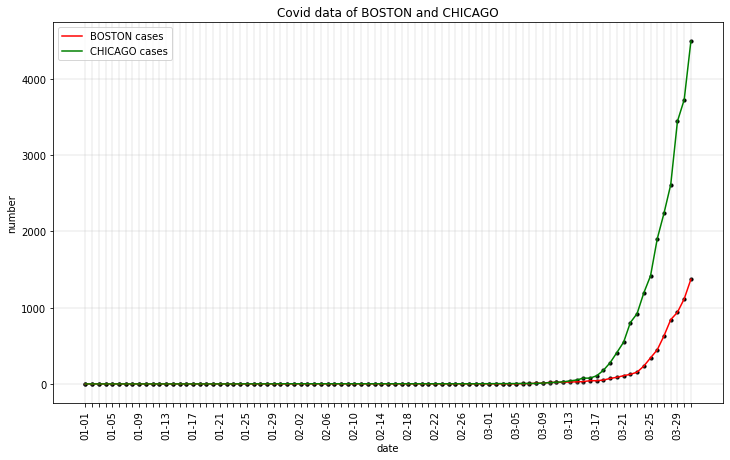

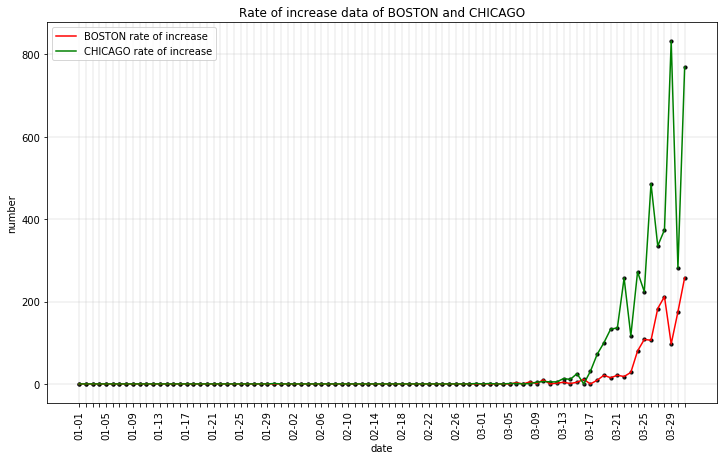

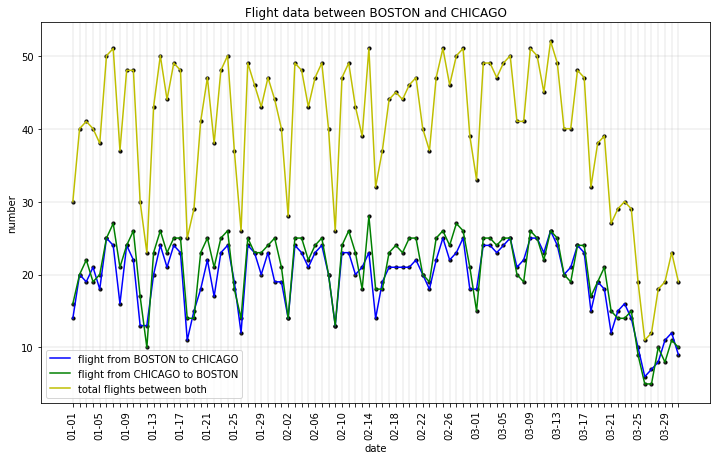

10707.0


In [15]:
plot_merged_cities('BOSTON','CHICAGO')

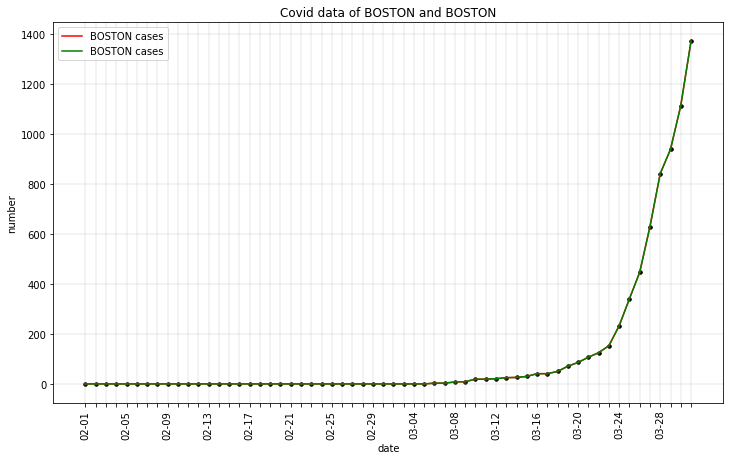

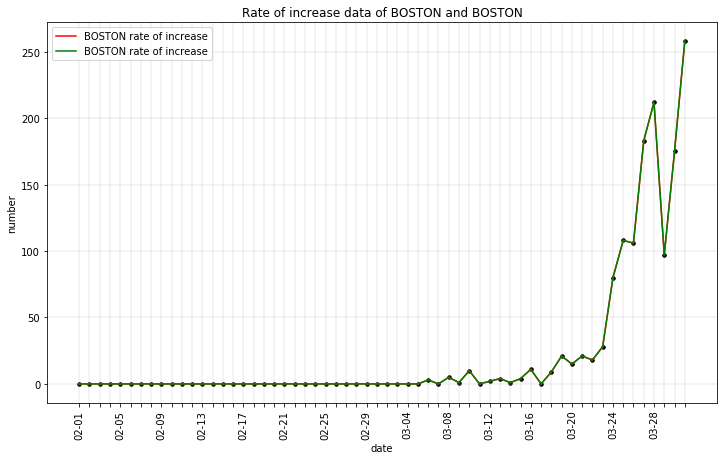

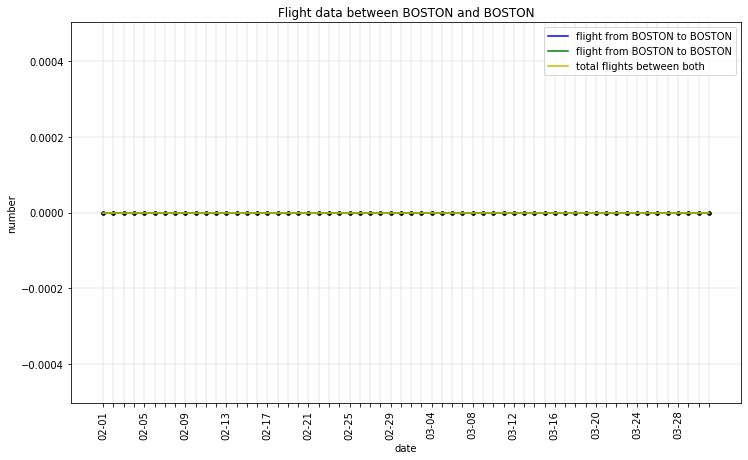

0.0


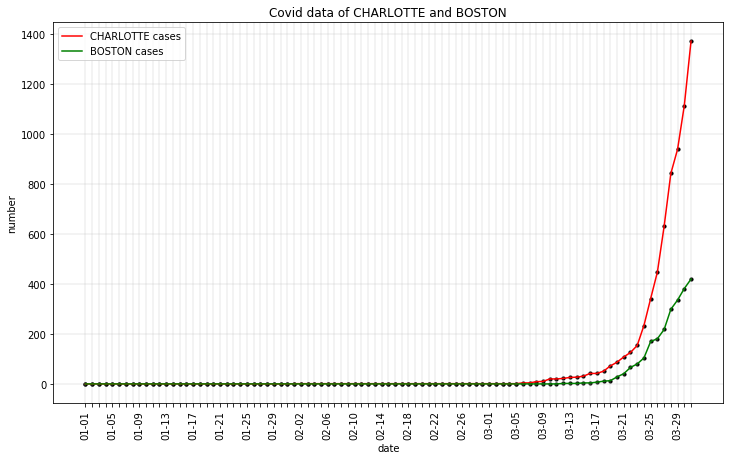

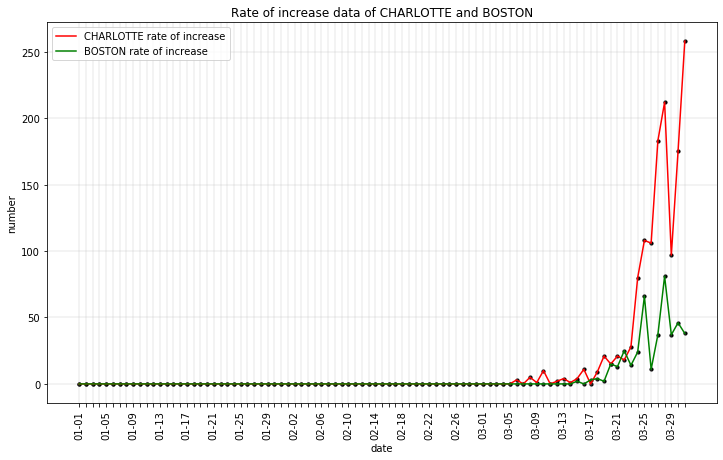

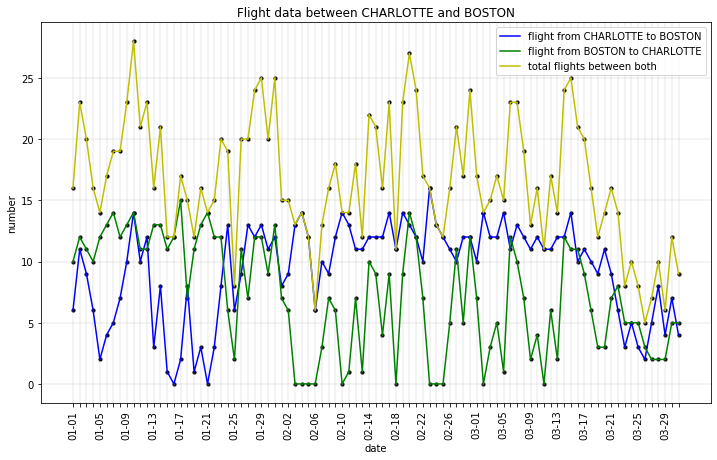

3090.0


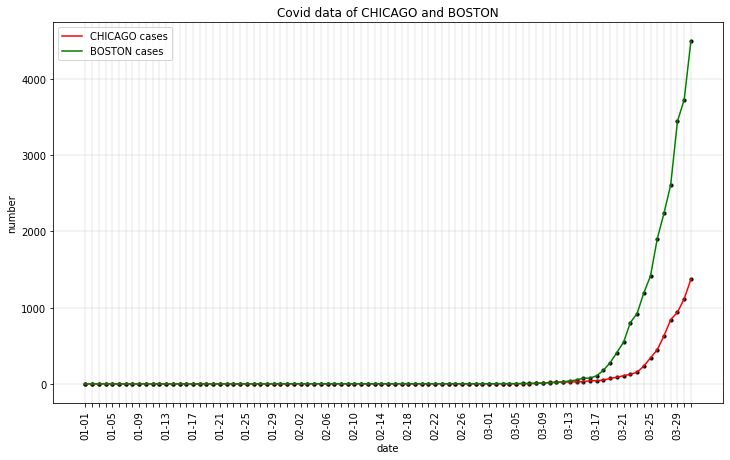

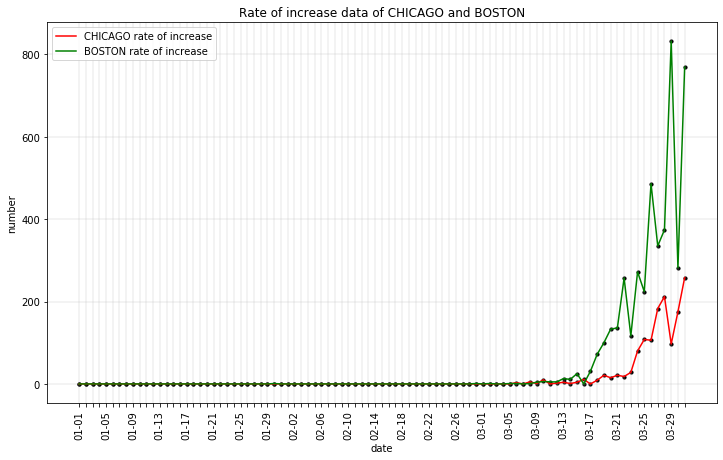

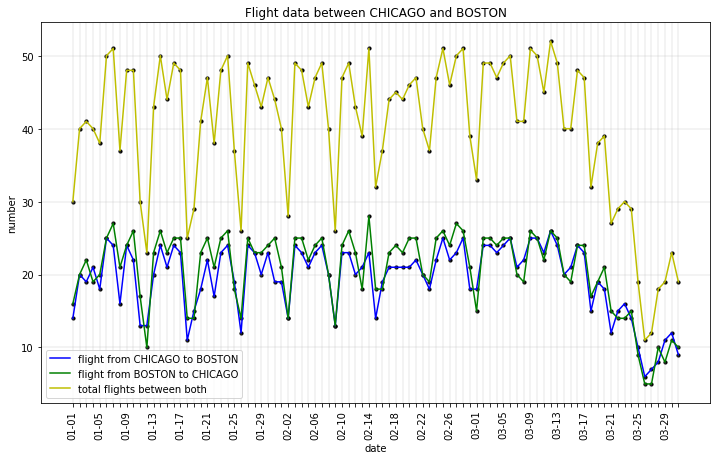

10707.0


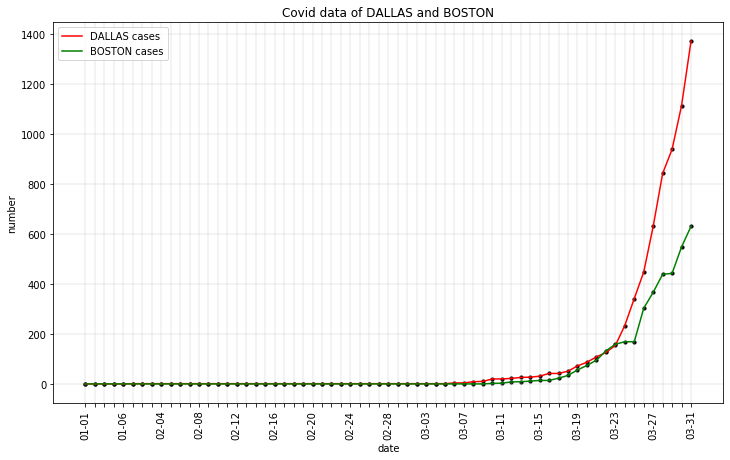

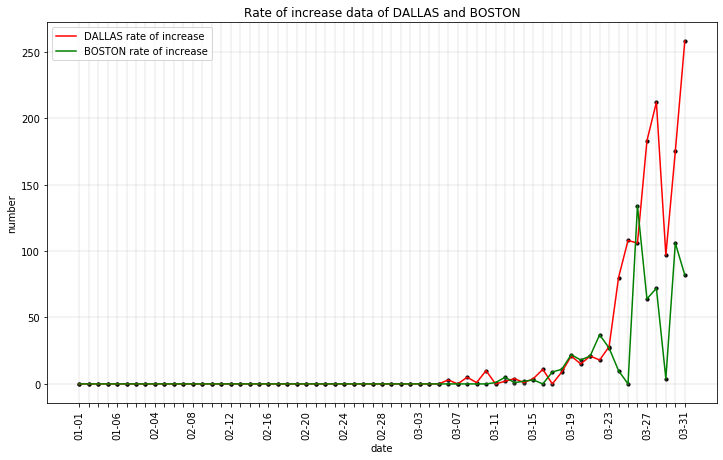

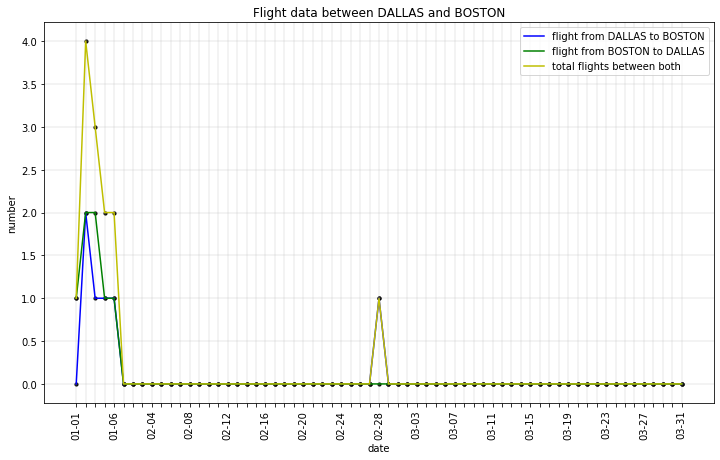

2083.0


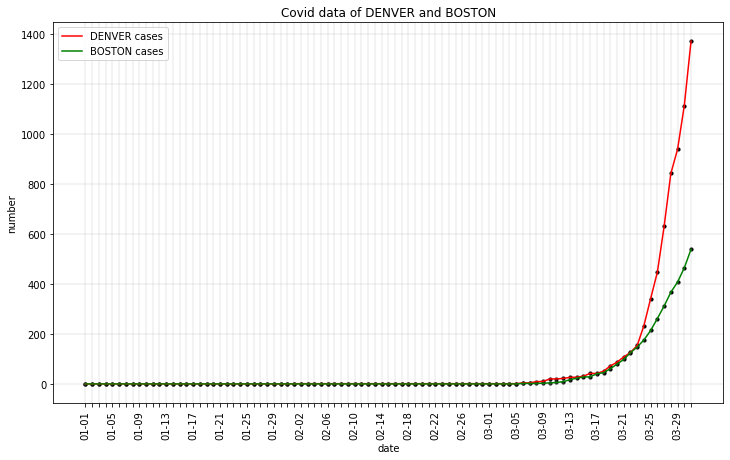

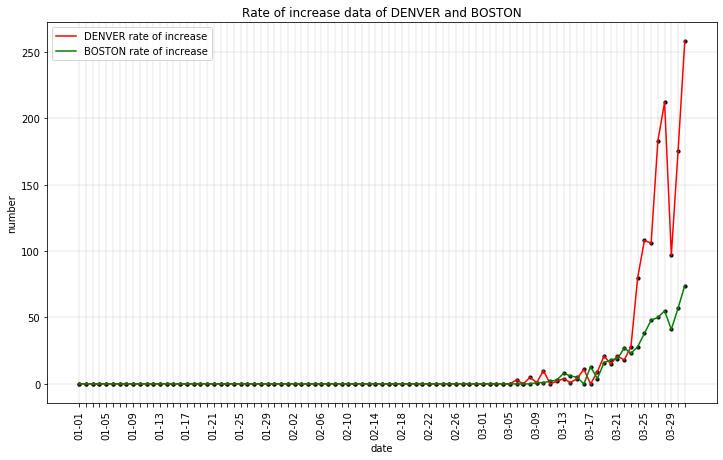

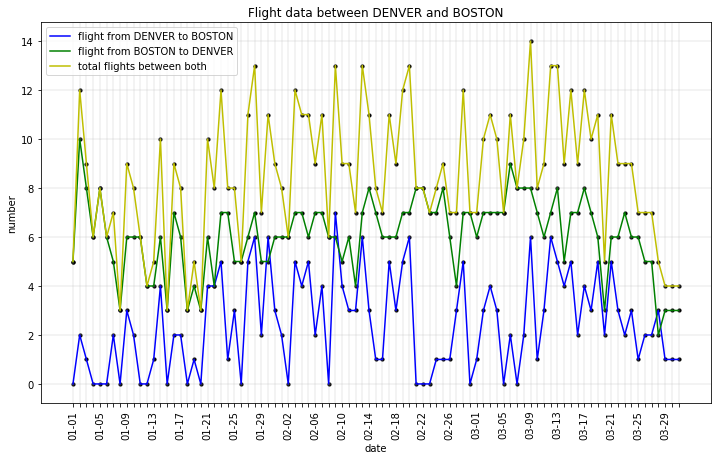

2484.0


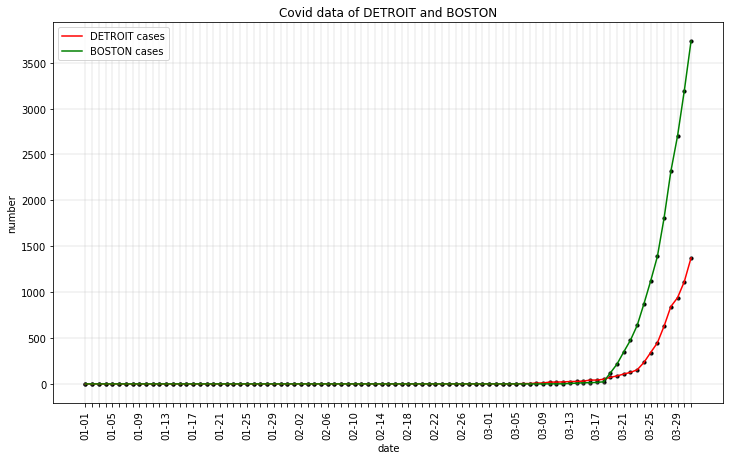

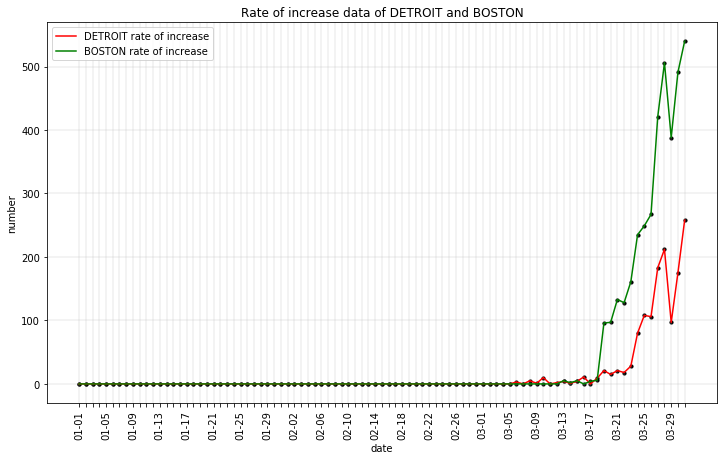

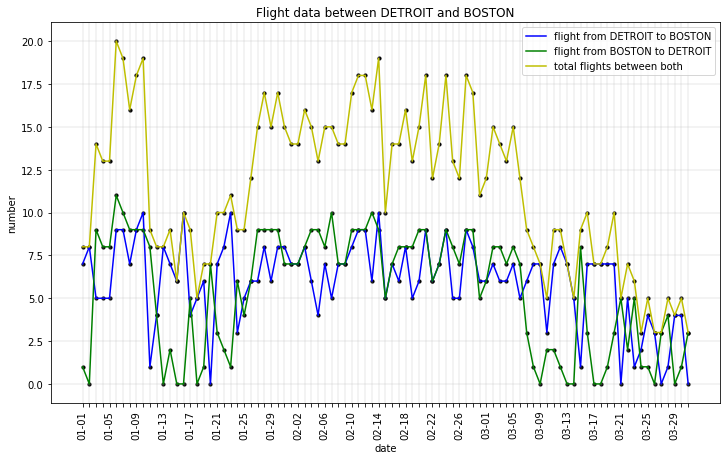

7307.0


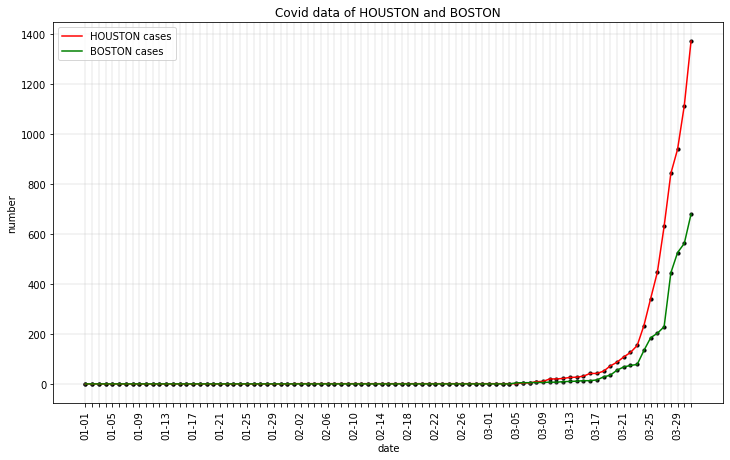

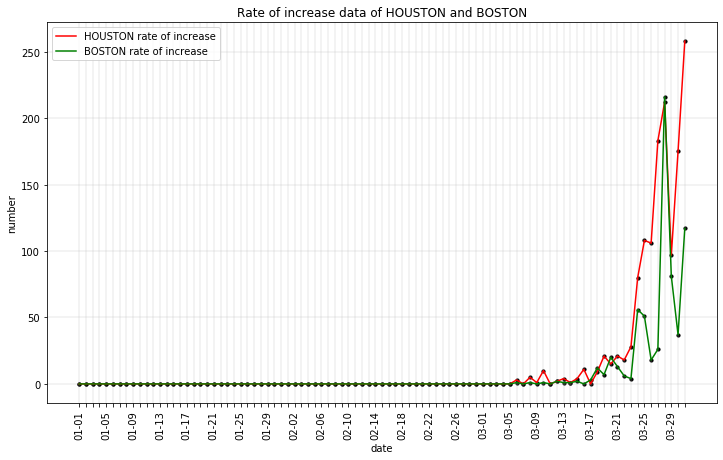

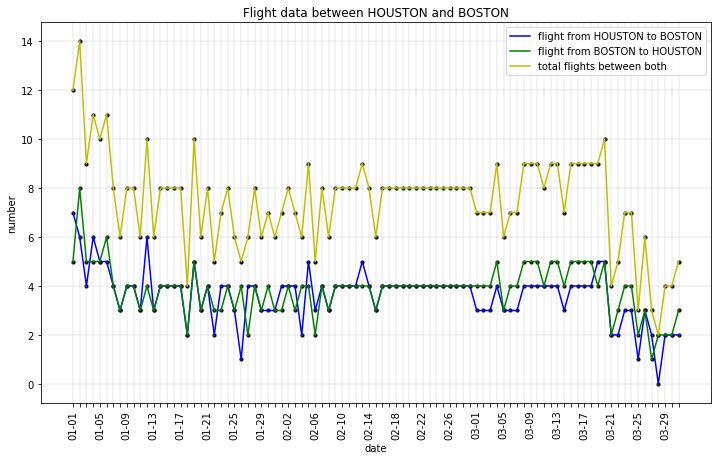

2005.0


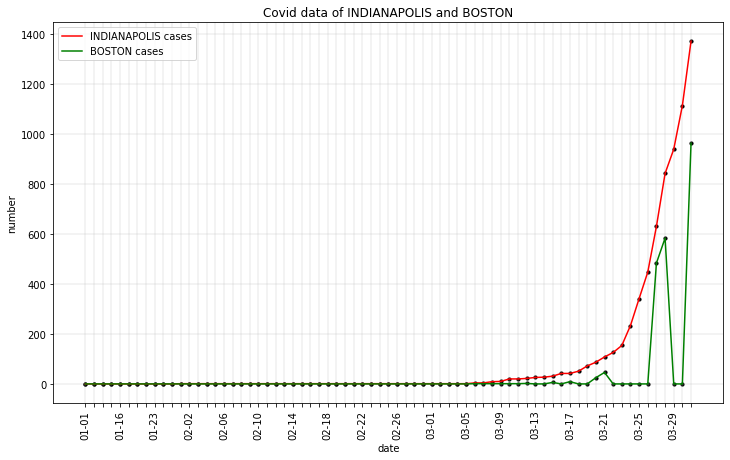

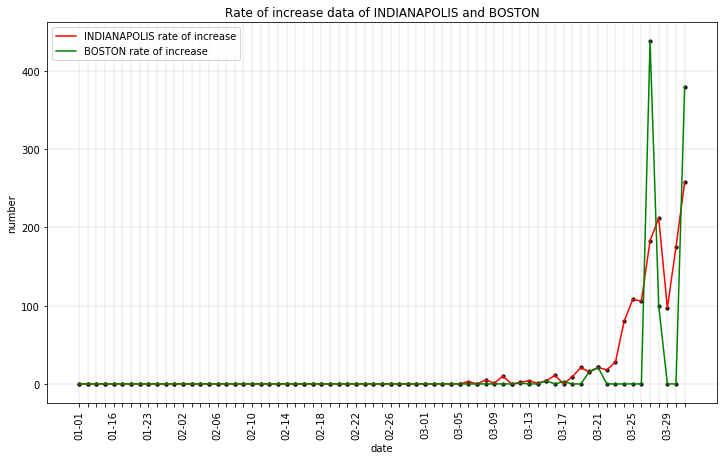

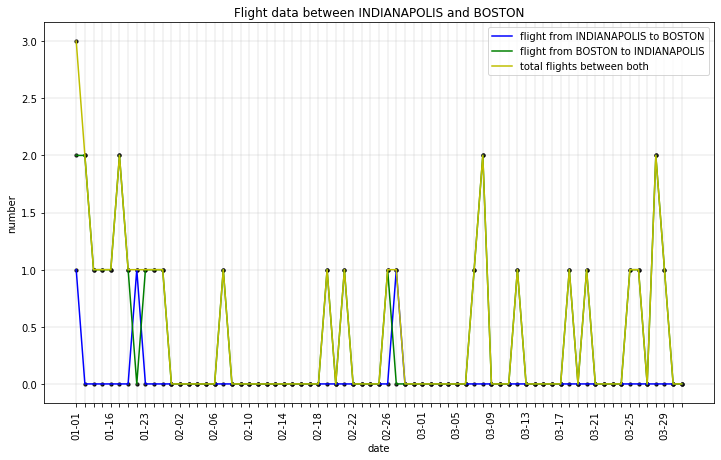

2860.0


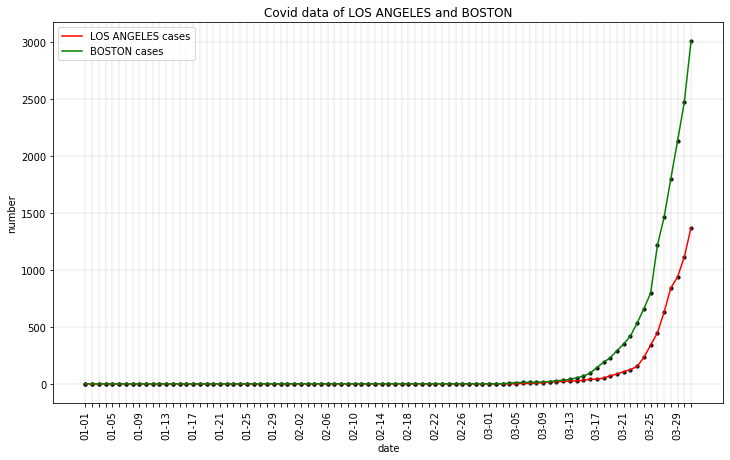

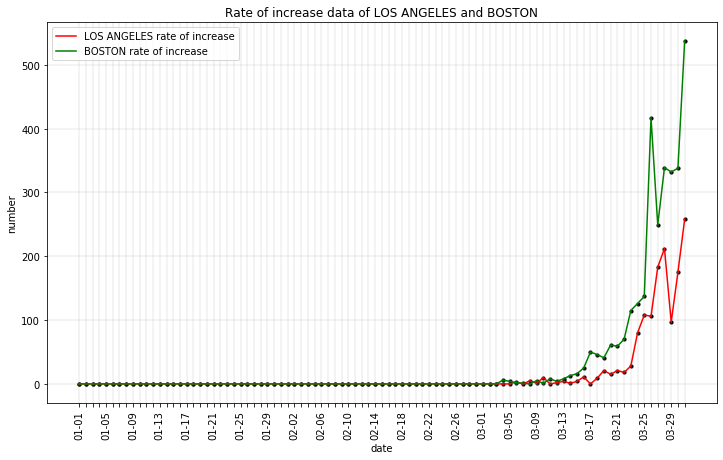

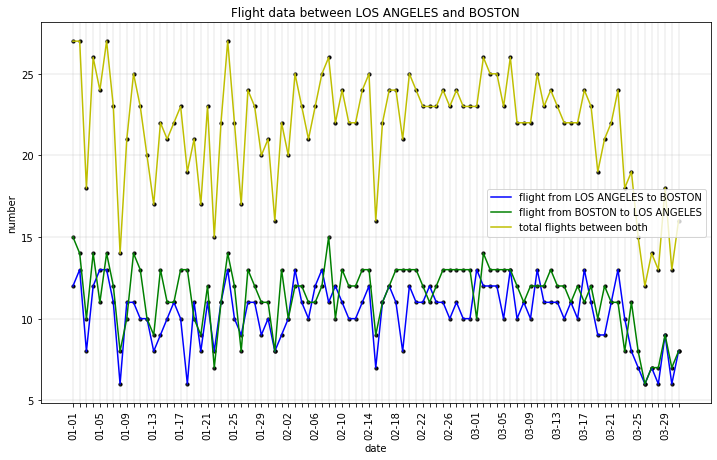

4629.0


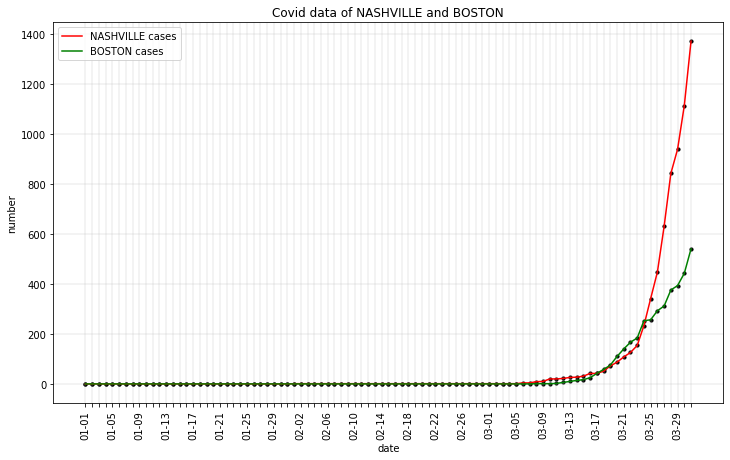

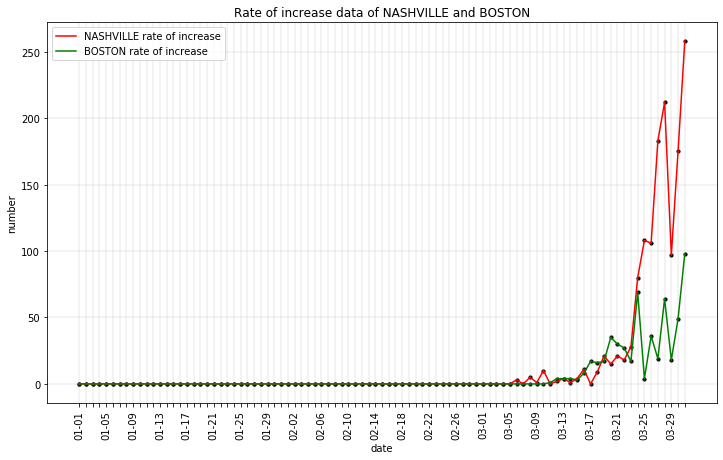

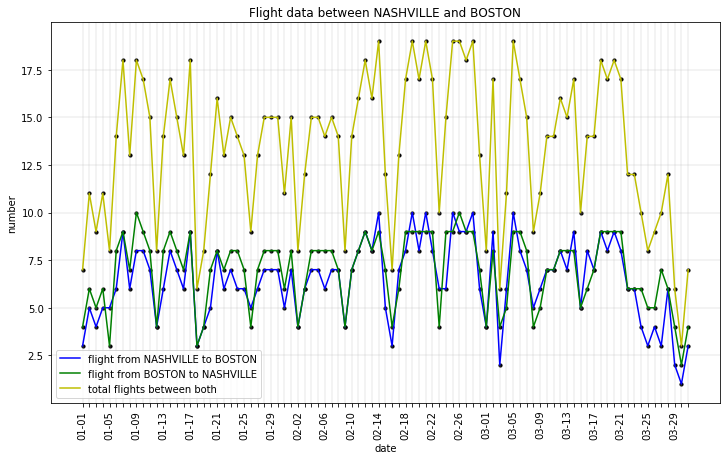

2516.0


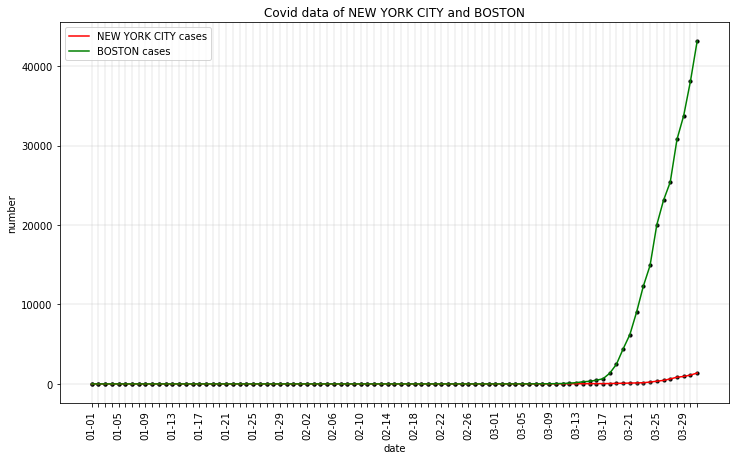

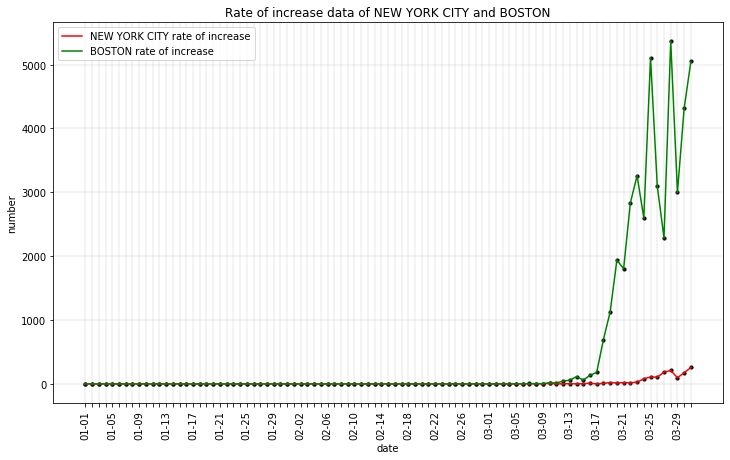

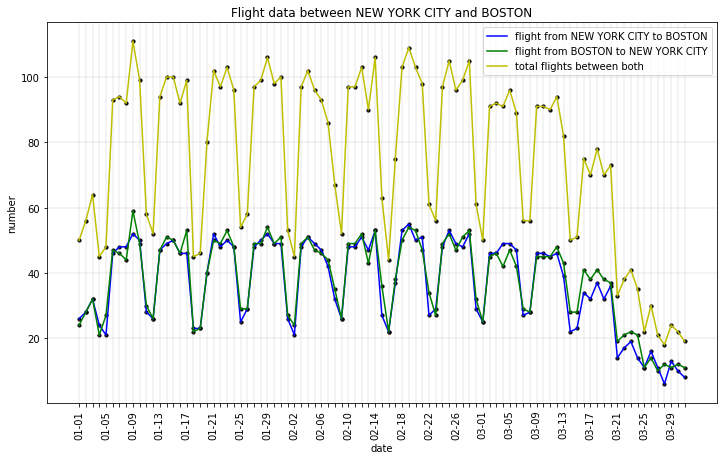

246682.0


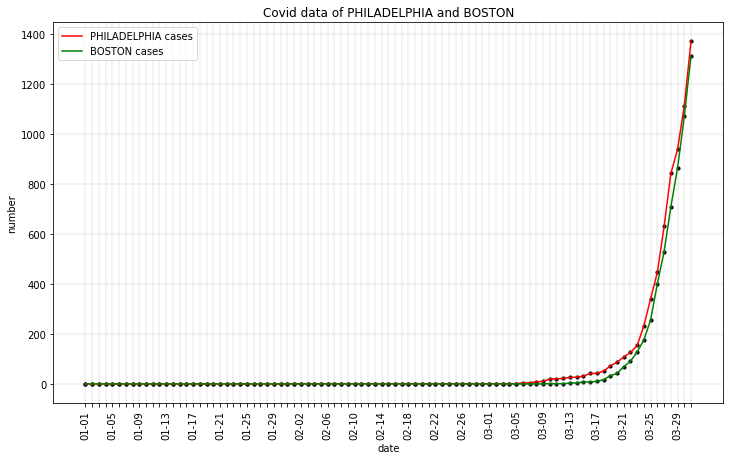

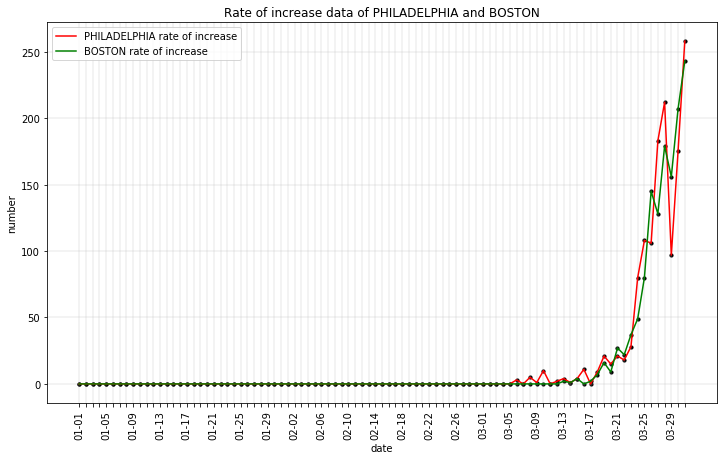

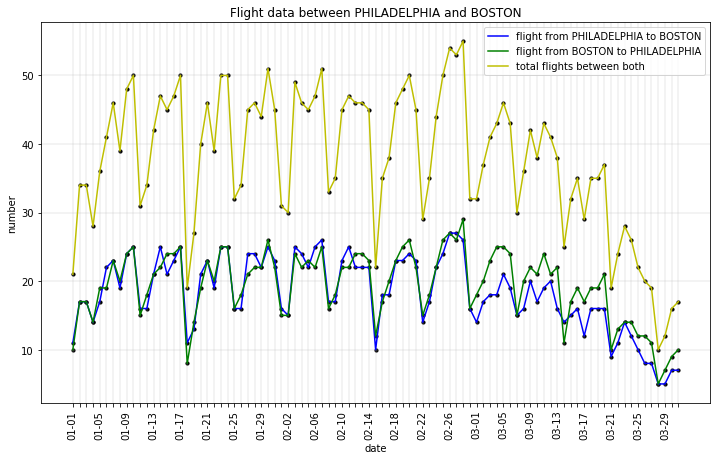

528.0


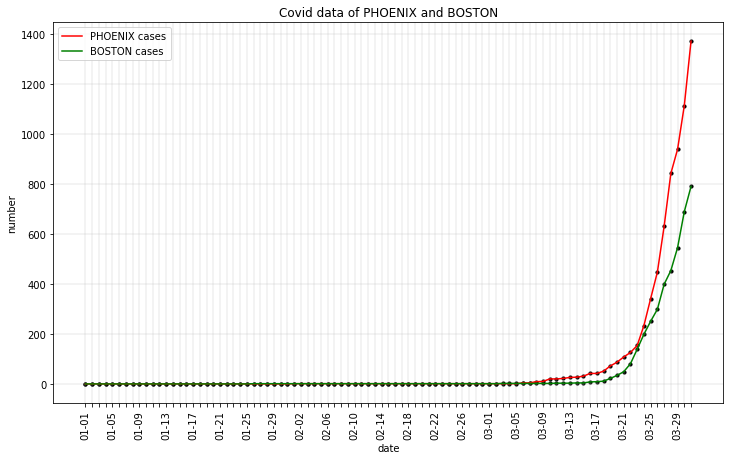

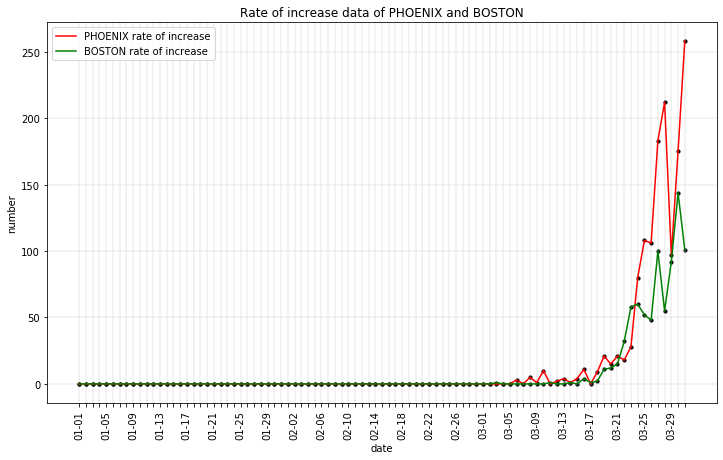

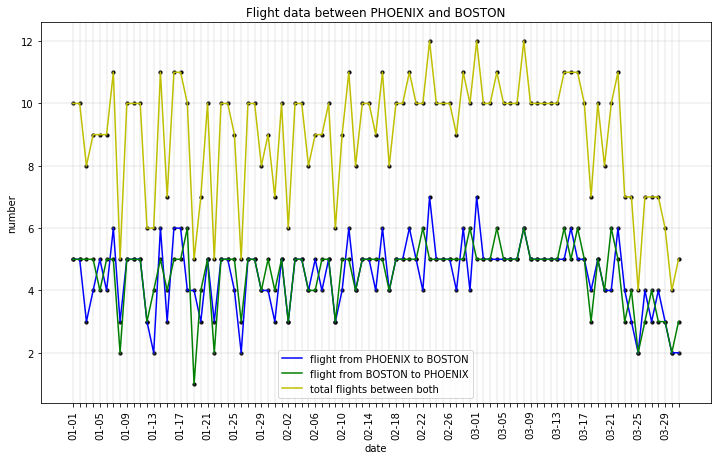

1511.0


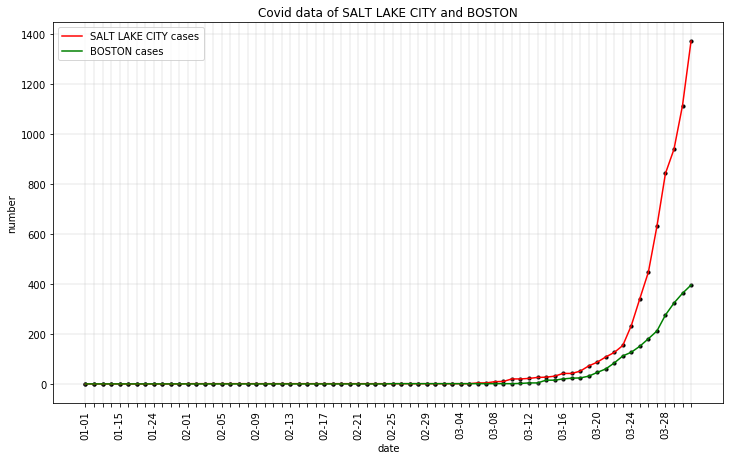

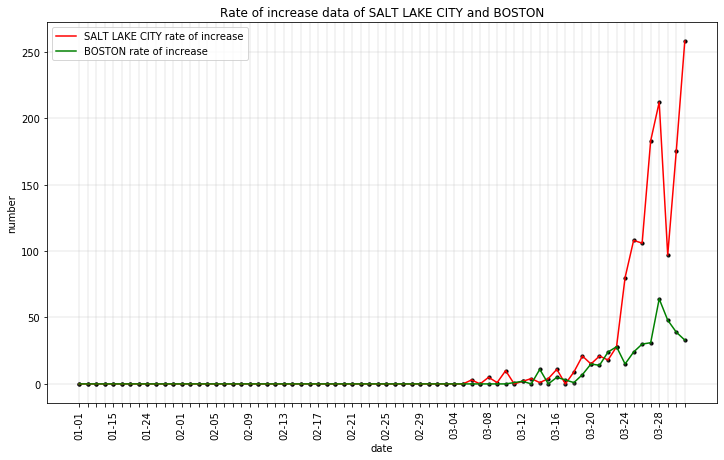

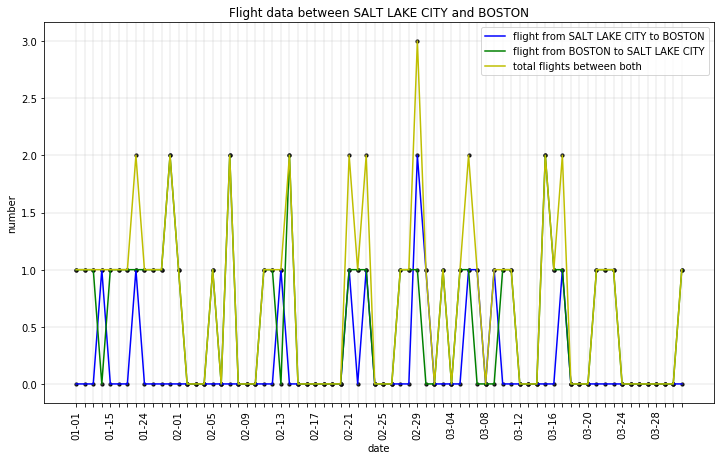

3158.0


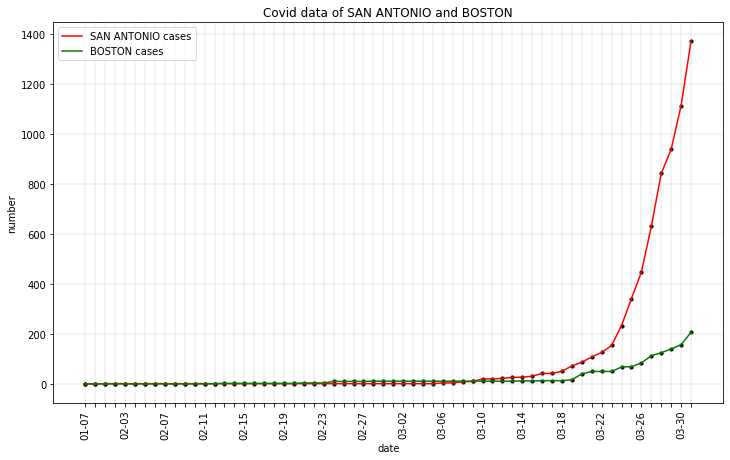

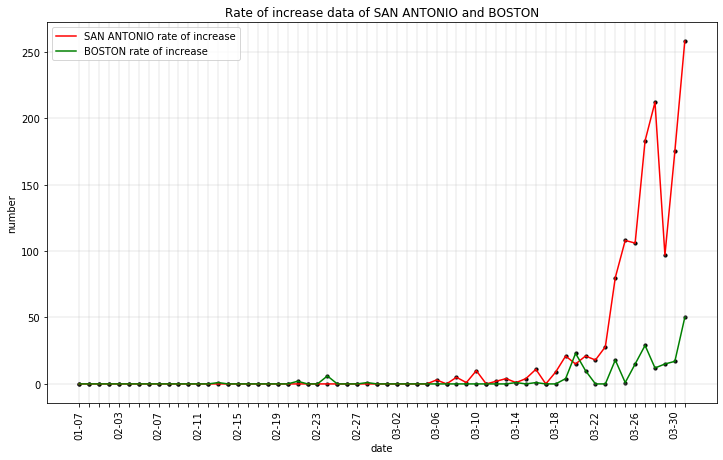

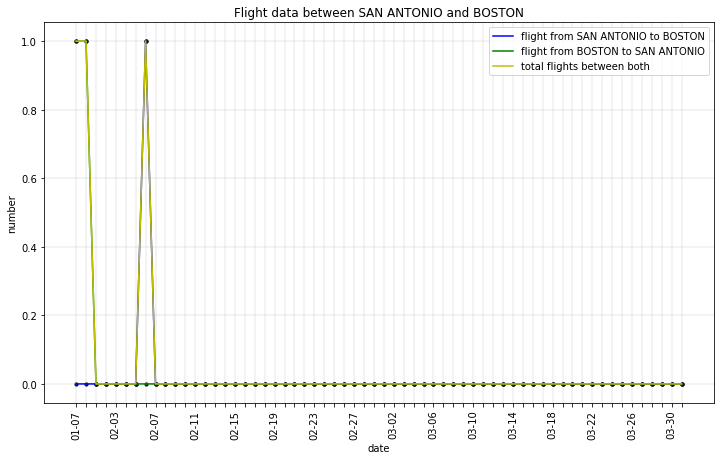

4386.0


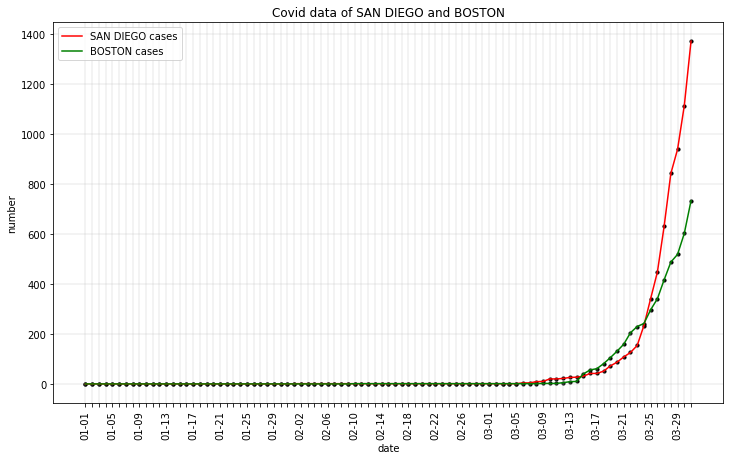

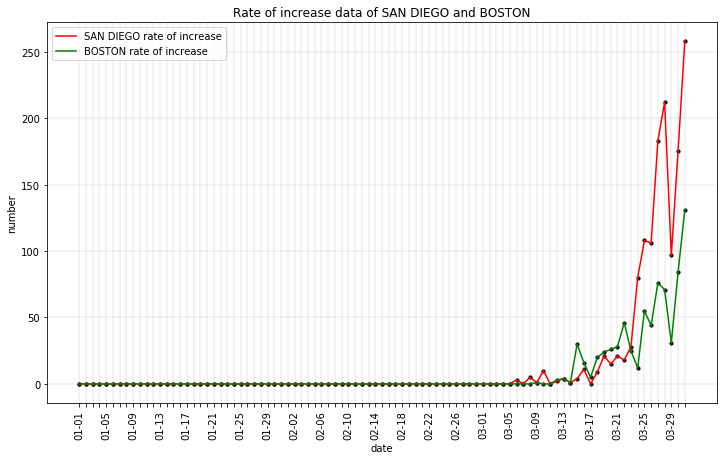

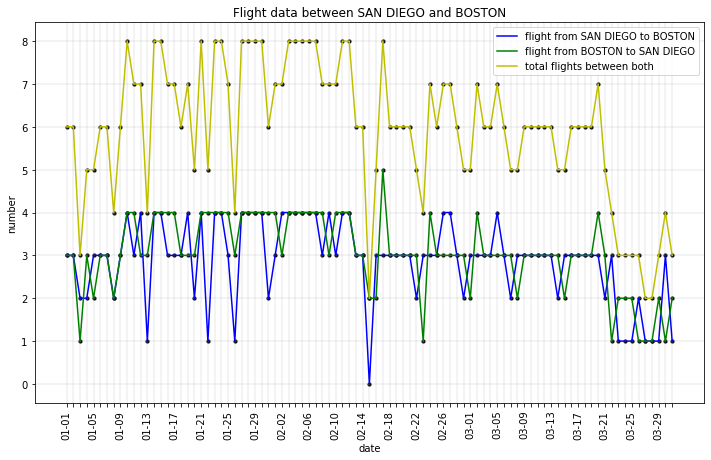

1704.0


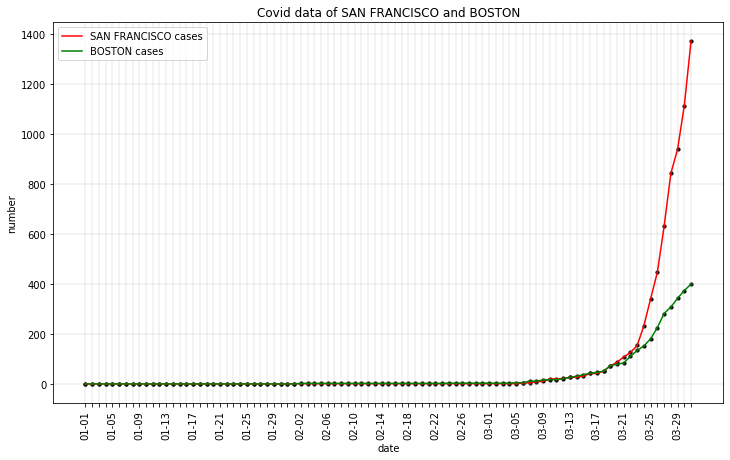

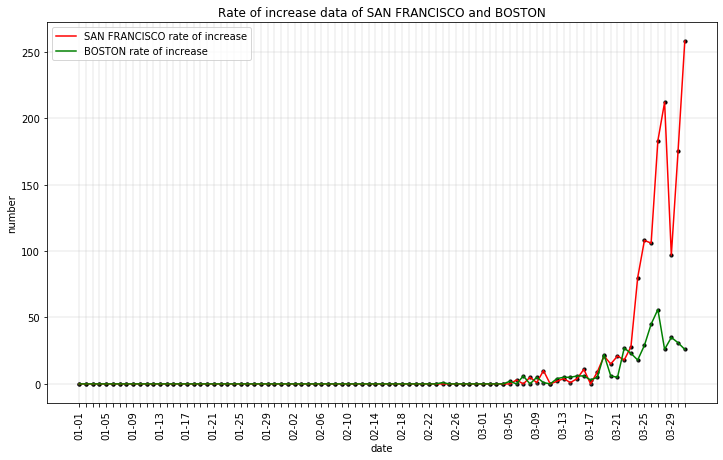

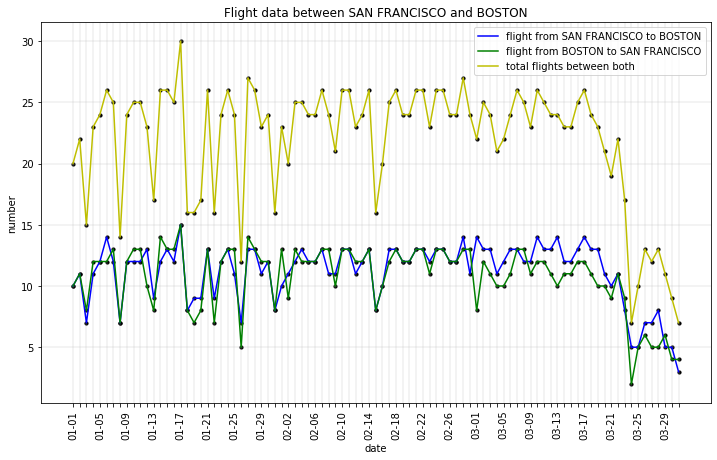

3189.0


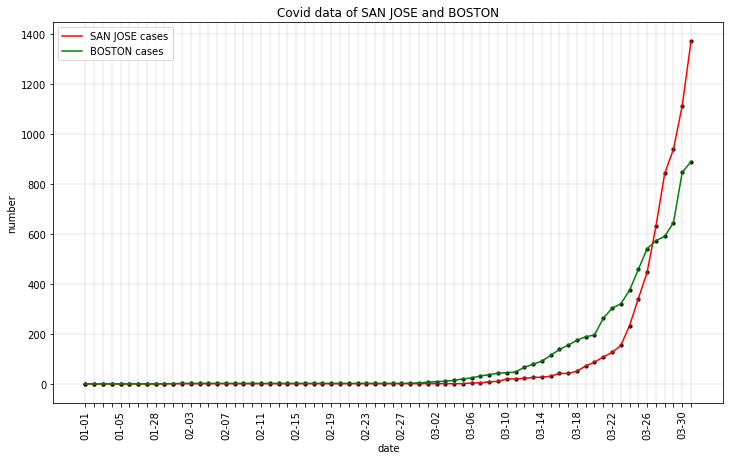

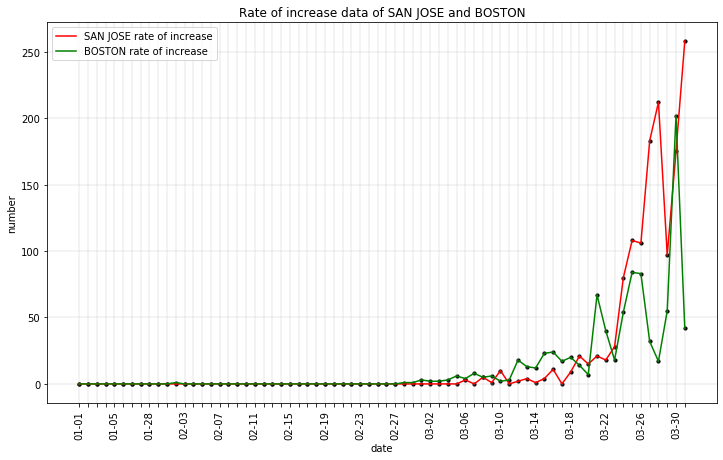

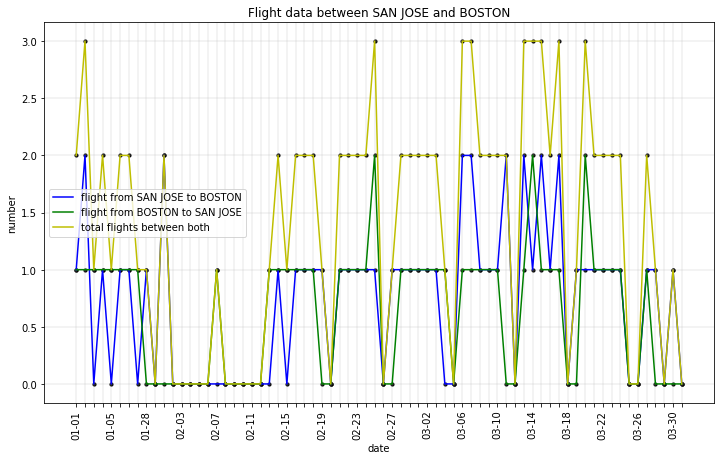

1281.0


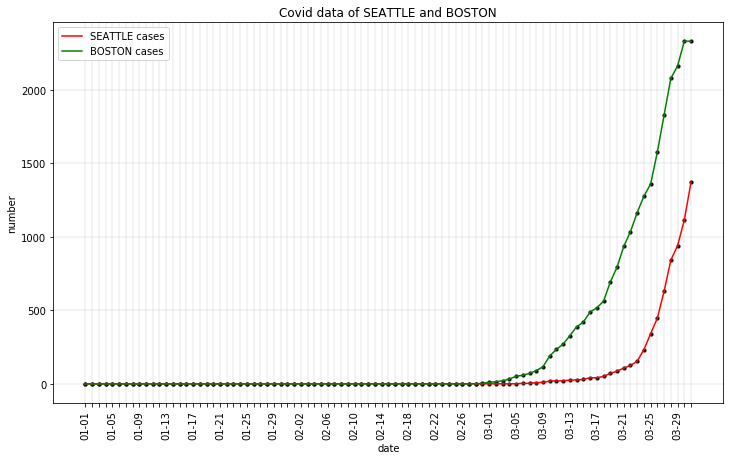

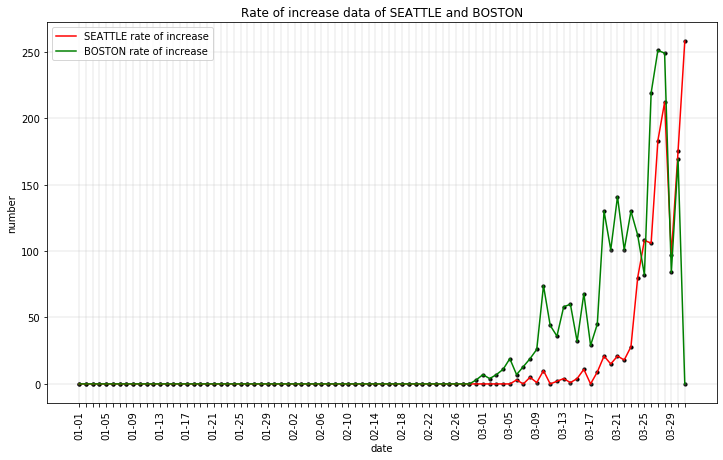

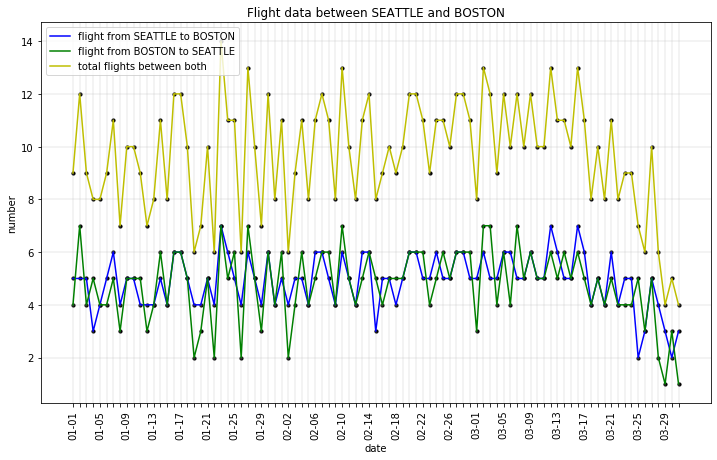

4842.0


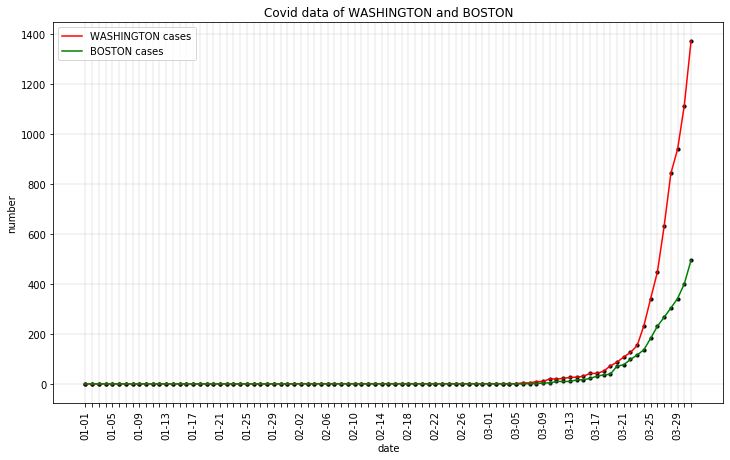

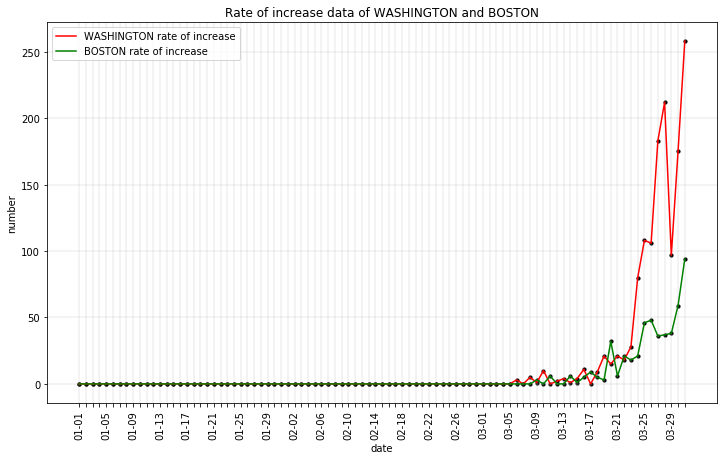

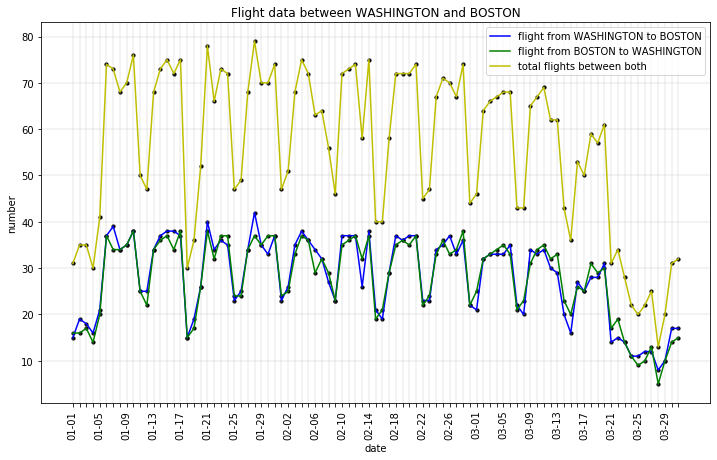

2650.0


In [16]:
for city1 in city_list:
    plot_merged_cities(city1, 'BOSTON')

In [17]:
def get_dtw_flight_data_for_each_city_pair(exclude_city_list = []):
    dtw_list = []
    flight_list = []
    name_list = []
    total_cities = len(city_list)
    for i in range(0,total_cities):
        city1 = city_list[i]
        if (city1 in exclude_city_list):
            continue
        for j in range(i + 1,total_cities):
            city2 = city_list[j]
            if (city2 in exclude_city_list):
                continue
            dtw_list.append(pairwise_city_data[city1][city2]['dtw'])
            flight_list.append(np.average(pairwise_city_data[city1][city2]['total_flight']))
            name_list.append(str(i)+','+str(j))
    return dtw_list, flight_list, name_list

In [18]:
def create_scatter_plot(x, y, name, x_lab = '', y_lab = '', plot_title = ''):
    plt.title(plot_title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.scatter(x, y)
    plt.show()
    
    plt.title(plot_title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.scatter(x, y)
    for i, txt in enumerate(name):
        plt.annotate(txt, (x[i], y[i]))
    plt.show()

In [19]:
dl, fl, nl = get_dtw_flight_data_for_each_city_pair(exclude_city_list = ['NEW YORK CITY'])

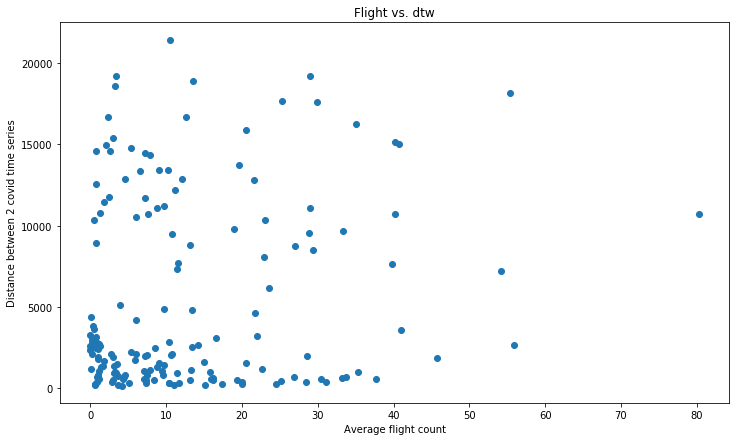

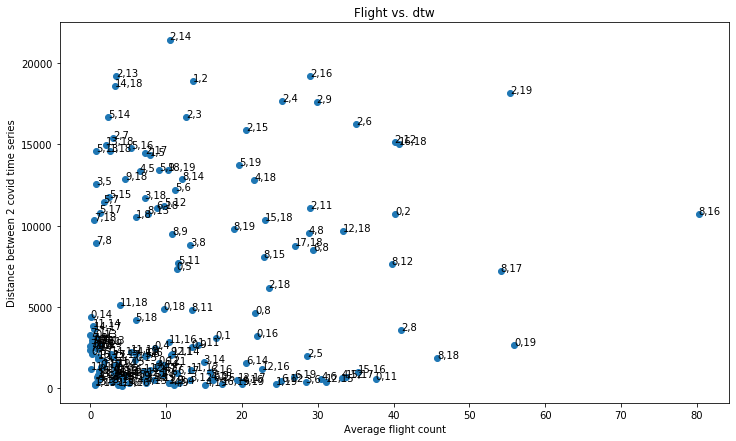

In [20]:
create_scatter_plot(fl, dl, nl, 'Average flight count', 'Distance between 2 covid time series', 'Flight vs. dtw')

In [21]:
city_list[2], city_list[19]

('CHICAGO', 'WASHINGTON')